# Setup

In [1]:
import torch
import numpy as np
import pandas as pd
import plotly.express as px
import sys
import training_utils as util
sys.path.append("../..")
from src.models.base_model import base_model

In [2]:
data_folder = "../../data/processed/graph_data_nohubs/"
models_folder = "../../data/models/"
experiments_folder = "../../data/experiments/design_space_experiment/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import random
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

# Utility

In [4]:
import copy

def load_data(folder_path,load_test = False,load_full=False):
    if load_test:
        names = ["train","validation","test"]
    else:
        names = ["train","validation"]
    datasets = []
    for name in names:
        path = folder_path+name+".pt"
        datasets.append(torch.load(path))
    
    return datasets

def initialize_features(data,feature,dim,inplace=False):
    if inplace:
        data_object = data
    else:
        data_object = copy.copy(data)
    for nodetype, store in data_object.node_items():
        if feature == "random":
            data_object[nodetype].x = torch.rand(store["num_nodes"],dim)
        if feature == "ones":
            data_object[nodetype].x = torch.ones(store["num_nodes"],dim)
    return data_object

def load_model(state_dict,params,metadata):
    model = base_model(params,metadata,supervision_types=[('gene_protein', 'gda', 'disease')])
    model.load_state_dict(state_dict)
    return model

def load_experiment(eid:int,date:str,metadata:tuple) -> tuple:
    """Returns tuple (model,params).
    date format: d_m_y"""
    df_path = f"{experiments_folder}experiment_{date}.parquet"
    weights_path = f"{experiments_folder}experiment_{eid}_{date}__.pth"

    df = pd.read_parquet(df_path)
    #TODO: this is only temporal, remove after fix
    df["conv_type"] = df.conv_type.apply(lambda x: x.split(".")[-1].rstrip("\'>"))
    df["activation"] = torch.nn.LeakyReLU
    params = df.loc[eid].to_dict()
    weights = torch.load(weights_path,map_location=torch.device(device))

    model = base_model(params,metadata)
    model.load_state_dict(weights)

    return model,params

def load_node_csv(path, index_col,type_col, **kwargs):
    """Returns node dataframe and a dict of mappings for each node type. 
    Each mapping maps from original df index to "heterodata index" { node_type : { dataframe_index : heterodata_index}}"""
    df = pd.read_csv(path, **kwargs,index_col=index_col)
    node_types = df[type_col].unique()
    mappings_dict = dict()
    for node_type in node_types:
        mapping = {index: i for i, index in enumerate(df[df[type_col] == node_type].index.unique())}
        mappings_dict[node_type] = mapping

    return df,mappings_dict

# Load data

In [5]:
train_data,val_data = load_data(data_folder+"split_dataset/")
full_data = torch.load(data_folder+"split_dataset/full_dataset.pt")

# Model

In [26]:
params = {'hidden_channels': 32,
 'conv_type': "SAGEConv",
 'batch_norm': True,
 'dropout': 0.1,
 'activation': torch.nn.LeakyReLU,
 'micro_aggregation': 'sum',
 'macro_aggregation': 'sum',
 'layer_connectivity': None,
 'L2_norm': True,
 'pre_process_layers': 1,
 'msg_passing_layers': 2,
 'post_process_layers': 1,
 'feature_dim': 10,
 'feature_type': 'ones',
 'weight_decay': 0.001,
 'lr': 0.001,
 'epochs': 400,
 'patience': 5,
 'delta': 0.01}

train_set = initialize_features(train_data,params["feature_type"],params["feature_dim"])
val_set = initialize_features(train_data,params["feature_type"],params["feature_dim"])

model = base_model(params,train_set.metadata())

In [7]:
labeled_edge_types = list(train_data.edge_label_index_dict.keys())
labeled_edge_types

[('gene_protein', 'ppi', 'gene_protein'),
 ('gene_protein', 'gda', 'disease'),
 ('gene_protein', 'pathway_protein', 'pathway'),
 ('disease', 'disease_disease', 'disease'),
 ('gene_protein', 'form_complex', 'complex'),
 ('disease', 'disease_disease', 'bert_group'),
 ('bert_group', 'disease_disease', 'bert_group')]

# Training and testing

0.6973683834075928
0.5822414755821228
0.5560131072998047
0.5369979739189148
0.5251196622848511
0.5140866041183472
0.5054045915603638
0.4991579055786133


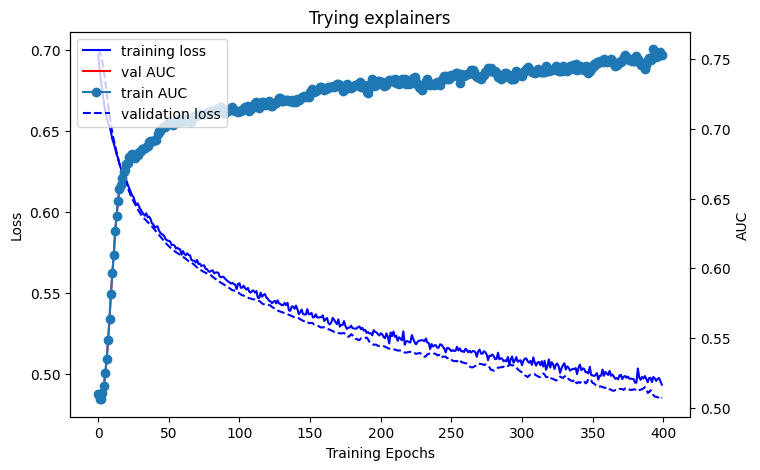

In [27]:
from sklearn.metrics import roc_auc_score

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params["weight_decay"])
train_losses = []
val_losses = []
train_scores = []
val_scores = []

metric = roc_auc_score
epochs = params["epochs"]
supervision_types = [('disease', 'disease_disease', 'disease'),('disease', 'disease_disease', 'bert_group')]

early_stopper = util.EarlyStopper(params["patience"],params["delta"])
for epoch in range(epochs):
    train_loss = util.train(model,optimizer,train_set,supervision_types)
    val_loss = util.get_val_loss(model,val_set,supervision_types)
    train_score = util.test(model,train_set,supervision_types,metric)
    val_score = util.test(model,val_set,supervision_types,metric)

    train_losses.append(train_loss)
    train_scores.append(train_score)
    val_scores.append(val_score)
    val_losses.append(val_loss)

    if epoch%50 == 0:
        print(train_loss)
    
    if early_stopper.early_stop(val_loss):
        print("Early stopping")
        break

val_auc = util.test(model,val_set,supervision_types,roc_auc_score)
curve_data = [train_losses,val_losses,train_scores,val_scores]

util.plot_training_stats("Trying explainers", *curve_data,"AUC")

In [28]:
util.full_test(model,train_set,supervision_types,200,False)

{('disease', 'disease_disease', 'disease'): [0.73, 0.65, 0.73, 198.0],
 ('disease', 'disease_disease', 'bert_group'): [0.78, 0.71, 0.78, 198.0]}

# Visualization

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
node_data,node_map = load_node_csv(data_folder+"nohub_graph_nodes.csv","node_index","node_type")
node_names = node_data[(node_data.node_type == "disease") | (node_data.node_type == "gene_protein")].sort_values(by="node_type").node_name.values
node_info = pd.read_csv(data_folder+"nohub_graph_node_data.csv")

In [11]:
@torch.no_grad()
def get_encodings(model,data):
    model.eval()
    encodings = model.encode(data)
    return encodings

def plot_pca(gene_encodings,disease_encodings,title,n_components,plot_components):

    z1 = disease_encodings.detach().cpu().numpy()
    z2 = gene_encodings.detach().cpu().numpy()

    z = np.concatenate([z1,z2])

    num_diseases = z1.shape[0]
    num_genes = z2.shape[0]

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(z)
    fig = px.scatter(components, x=plot_components[0], y=plot_components[1], color=['b']*num_diseases + ['r']*num_genes, title=title,hover_name=node_names)

    fig.show()

def plot_pca_3D(gene_encodings,disease_encodings,title,n_components,plot_components):

    z1 = disease_encodings.detach().cpu().numpy()
    z2 = gene_encodings.detach().cpu().numpy()
    gene_encodings = encodings["gene_protein"]
    disease_encodings = encodings["disease"]

    return gene_encodings, disease_encodings
    z = np.concatenate([z1,z2])

    num_diseases = z1.shape[0]
    num_genes = z2.shape[0]

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(z)
    fig = px.scatter_3d(components, x=plot_components[0], y=plot_components[1],z=plot_components[2], color=['b']*num_diseases + ['r']*num_genes, title=title,hover_name=node_names)

    fig.show()

def plot_pca_with_communities(gene_encodings,disease_encodings,title,n_components,plot_components,node_info,partition="comunidades_louvain"):

    z1 = disease_encodings.detach().cpu().numpy()
    z2 = gene_encodings.detach().cpu().numpy()

    z = np.concatenate([z1,z2])

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(z)

    node_clusters = node_info[["node_index",partition]].dropna()
    node_map_series = pd.Series(node_map["disease"],name="tensor_index")
    node_clusters = node_clusters.merge(node_map_series,left_on="node_index",right_index=True,how="right").sort_values(by="tensor_index").fillna(-1)

    df = pd.DataFrame(components)
    df["node_names"] = node_names
    df = df.merge(node_clusters[["tensor_index",partition]],left_index=True,right_on="tensor_index",how="left").reset_index(drop=True).fillna(-2)
    df[partition] = df[partition].astype(str)
    
    fig = px.scatter(df, x=plot_components[0], y=plot_components[1], color=partition, title=title,hover_name="node_names")
    fig.show()

def plot_pca_all_types(encodings_dict,title,n_components,plot_components):

    encodings = [tensor.detach().cpu().numpy() for tensor in encodings_dict.values()]
    z = np.concatenate(encodings)

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(z)
    component_df = pd.DataFrame(components)

    sub_dfs = []
    for node_type in encodings_dict.keys():
        sub_df = node_data[node_data.node_type == node_type]
        node_map_series = pd.Series(node_map[node_type],name="tensor_index")
        sub_df = sub_df.merge(node_map_series,left_on="node_index",right_index=True,how="right").sort_values(by="tensor_index").reset_index(drop=True)

        sub_dfs.append(sub_df)

    df = pd.concat(sub_dfs,ignore_index=True)
    df = df.merge(component_df,left_index=True,right_index=True)

    fig = px.scatter(df, x=plot_components[0], y=plot_components[1], color="node_type", title=title,hover_name="node_name")

    fig.show()

def plot_umap(encodings_dict,n_components,plot_components,title,colors):
    node_info = pd.read_csv(data_folder+"nohub_graph_node_data.csv")
    encodings = [tensor.detach().cpu().numpy() for tensor in encodings_dict.values()]
    z = np.concatenate(encodings)
    umap = UMAP(n_components=n_components, init='random', random_state=0) 
    proj = umap.fit_transform(z)
    proj_df = pd.DataFrame(proj)

    sub_dfs = []
    for node_type in encodings_dict.keys():
        sub_df = node_info[node_info.node_type == node_type]
        node_map_series = pd.Series(node_map[node_type],name="tensor_index")
        sub_df = sub_df.merge(node_map_series,left_on="node_index",right_index=True,how="right").sort_values(by="tensor_index").reset_index(drop=True)

        sub_dfs.append(sub_df)

    df = pd.concat(sub_dfs,ignore_index=True)
    df = df.merge(proj_df,left_index=True,right_index=True).fillna(-1).astype({"comunidades_infomap":str,"comunidades_louvain":str})

    fig = px.scatter(df, x=plot_components[0], y=plot_components[1], color=colors, title=title,hover_name="node_name")

    fig.show()

def plot_tsne(encodings_dict,n_components,plot_components,title,colors):
    node_info = pd.read_csv(data_folder+"nohub_graph_node_data.csv")
    encodings = [tensor.detach().cpu().numpy() for tensor in encodings_dict.values()]
    z = np.concatenate(encodings)
    tsne = TSNE(n_components=n_components, random_state=0)
    proj = tsne.fit_transform(z)
    proj_df = pd.DataFrame(proj)

    sub_dfs = []
    for node_type in encodings_dict.keys():
        sub_df = node_info[node_info.node_type == node_type]
        node_map_series = pd.Series(node_map[node_type],name="tensor_index")
        sub_df = sub_df.merge(node_map_series,left_on="node_index",right_index=True,how="right").sort_values(by="tensor_index").reset_index(drop=True)

        sub_dfs.append(sub_df)

    df = pd.concat(sub_dfs,ignore_index=True)
    df = df.merge(proj_df,left_index=True,right_index=True).fillna(-1).astype({"comunidades_infomap":str,"comunidades_louvain":str})

    fig = px.scatter(df, x=plot_components[0], y=plot_components[1], color=colors, title=title,hover_name="node_name")

    fig.show()

In [30]:
encodings = get_encodings(model,train_set)

In [35]:
plot_umap(encodings,2,(0,1),"aver","degree_dd")

In [32]:
plot_tsne(encodings,2,(0,1),"aver","comunidades_louvain")

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [33]:
node_info

node_index       node_id  \
0               0             1   
1           19599      C0019209   
2           34251  R-HSA-114608   
3             653         10422   
4           13168         63891   
...           ...           ...   
35834       30820      C3151471   
35835       30959      C3278148   
35836       33955      C4722518   
35837       32968      C4289709   
35838       32509      C4048304   

                                           node_name     node_type  \
0                                               A1BG  gene_protein   
1                                       Hepatomegaly       disease   
2                            Platelet degranulation        pathway   
3                                              UBAC1  gene_protein   
4                                             RNF123  gene_protein   
...                                              ...           ...   
35834  AMYLOID CARDIOMYOPATHY, TRANSTHYRETIN-RELATED       disease   
35835              BERNARD-SOULIER SYNDROME, TYPE A1       disease   
35836               Triple-Negative Breast Carcinoma       disease   
35837                               DOCK8 Deficiency       disease   
35838            Undifferentiated round cell sarcoma       disease   

            node_source  comunidades_infomap  comunidades_louvain  degree_gda  \
0              disgenet                  NaN                  NaN         2.0   
1              disgenet                  NaN                  NaN        54.0   
2      primekg_REACTOME                  NaN                  NaN         0.0   
3                hippie                  NaN                  NaN         0.0   
4              disgenet                  NaN                  NaN         2.0   
...                 ...                  ...                  ...         ...   
35834          disgenet                766.0                 22.0         0.0   
35835          disgenet               1106.0                252.0         0.0   
35836          disgenet                 17.0                  2.0         0.0   
35837          disgenet                127.0                 17.0         0.0   
35838          disgenet                 21.0                  7.0         0.0   

       degree_pp  degree_dd  
0           12.0        0.0  
1            0.0        0.0  
2          129.0        0.0  
3           36.0        0.0  
4           24.0        0.0  
...          ...        ...  
35834        0.0        1.0  
35835        0.0        1.0  
35836        0.0        1.0  
35837        0.0        1.0  
35838        0.0        1.0  

[35839 rows x 10 columns]